# Sentiment Analysis Notebook

Sentiment analysis notebook with a simple RNN by Basel.

## 1. Includes

In [23]:
# Basics
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import re as reg

# NLP refs
import nltk
from nltk.corpus import stopwords
from nltk.tokenize import word_tokenize
from nltk.stem import PorterStemmer


nltk.download('punkt')
nltk.download('punkt_tab')
nltk.download('stopwords')
nltk.download('wordnet')

# THE BIG GUNS
from sklearn.model_selection import train_test_split
import tensorflow as tf
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow.keras.models import Sequential
from tensorflow.keras.utils import to_categorical
from tensorflow.keras.layers import Embedding, SimpleRNN, Dense, Dropout


# Eval
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score
from sklearn.metrics import confusion_matrix, classification_report



pd.set_option('display.max_colwidth', 100)
plt.style.use('ggplot')

[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package punkt_tab to /root/nltk_data...
[nltk_data]   Package punkt_tab is already up-to-date!
[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package wordnet to /root/nltk_data...
[nltk_data]   Package wordnet is already up-to-date!


## 2. Dataset info

In [2]:

splits = {'train': 'train_df.csv', 'validation': 'val_df.csv', 'test': 'test_df.csv'}
df = pd.read_csv("hf://datasets/Sp1786/multiclass-sentiment-analysis-dataset/" + splits["train"])
print(f"Dataset shape: {df.shape}")
print("\nFirst few rows:")
df.head()

/usr/local/lib/python3.11/dist-packages/huggingface_hub/utils/_auth.py:94: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


Dataset shape: (31232, 4)

First few rows:


,id,text,label,sentiment
0,9536,"Cooking microwave pizzas, yummy",2,positive
1,6135,Any plans of allowing sub tasks to show up in the widget?,1,neutral
2,17697,"I love the humor, I just reworded it. Like saying 'group therapy' instead`a 'gang banging'. Kee...",2,positive
3,14182,naw idk what ur talkin about,1,neutral
4,17840,That sucks to hear. I hate days like that,0,negative


In [3]:
print("nulls:")
df.isnull().sum()

nulls:


,0
id,0
text,0
label,0
sentiment,0


In [4]:
print("has links?")
df[df['text'].str.contains('https?')].head()

has links?


,id,text,label,sentiment
21,14653,(bye) plurk out muna. will be back when im done reading the book http://plurk.com/p/rq9c7,1,neutral
24,2900,http://twitpic.com/3ernb - Loving The Jumper,2,positive
54,19253,Download movie 'Ben 10: Alien Force' http://tinyurl.com/czb7b2 cool #movie,2,positive
64,172,URL in previous post (to timer job) should be http://bit.ly/a4Fdb. I`d removed space which messe...,0,negative
102,13643,_nicole http://twitpic.com/4t6qx - i have the exact same pic except it`s my hubby & my chihuahua...,2,positive


In [5]:
print("all english letters?")
df[df['text'].str.contains('[^\x00-\x7F]')].head()

all english letters?


,id,text,label,sentiment
91,6059,"The app is great, and I´ve started to use it rather than wunderlist. Just 3 stars because I don´...",1,neutral
174,8112,"💩👎💩👎💩👎💩 👻☠️ IMPOSSIBLE TO DELETE LIST, OR SUB LISTS (TABS)!!! ☠️👻 REGRET v2.0 UPGRADE!! 👎💩👎💩👎💩👎💩...",0,negative
185,4095,Es muy útil para mantener las aplicaciones del celular cerradas mientras trabajas.,2,positive
241,2091,the app and widɡet are very ɡood. Will change to 5 start when I can be able to add task using go...,1,neutral
414,26054,"ohhhh, how sad...I didnï¿½t get it!",0,negative


## 3. The Prep Kitchen (Preprocessing)

In [6]:
def cleaner(text):
    text = text.lower()
    text = reg.sub(r'http\S+|www\S+|https\S+', '', text)
    text = reg.sub(r'@\w+', '', text)
    text = reg.sub(r'[^a-zA-Z\s]', '', text)
    text = reg.sub(r'\s+', ' ', text).strip()
    return text
df['cleaned_text'] = df['text'].apply(cleaner)
print("Any stragglers?")
df[df['cleaned_text'].str.contains('[^\x00-\x7F]')].head()


Any stragglers?


,id,text,label,sentiment,cleaned_text


In [7]:
def preprocesser(text):
    # tokenize
    tokens = word_tokenize(text)
    stop_words = set(stopwords.words('english'))
    tokens = [token for token in tokens if token not in stop_words]

    # stem
    stemmer = PorterStemmer()
    stemmed_tokens = [stemmer.stem(token) for token in tokens]

    processed_text = ' '.join(stemmed_tokens)

    return processed_text

df['processed_text'] = df['cleaned_text'].apply(preprocesser)
df['processed_text'].head()

,processed_text
0,cook microwav pizza yummi
1,plan allow sub task show widget
2,love humor reword like say group therapi insteada gang bang keep mom back hahaha
3,naw idk ur talkin
4,suck hear hate day like


## 4. Divorcing the dataset (Splitting)

In [8]:
X_train, X_test, y_train, y_test = train_test_split(
    df['processed_text'], df['label'], test_size=0.2, random_state=42
)
print("Training set shape:", X_train.shape)
print("Testing set shape:", X_test.shape)

Training set shape: (24985,)
Testing set shape: (6247,)


## 5. CBOWing and stuff (Tokenization/Padding)

In [9]:
tokenizer = Tokenizer(num_words=1000, oov_token="<OOV>")
tokenizer.fit_on_texts(X_train)

sequences = tokenizer.texts_to_sequences(X_train)

padded_sequences = pad_sequences(sequences,
                                maxlen=150,
                                padding='post',
                                truncating='post')

print("Original text:", X_train[0])
print("Tokenized sequence:", sequences[0])
print("Shape of padded sequences:", padded_sequences.shape)
print("Example of padded sequence:", padded_sequences[0])

X = padded_sequences
y = df['label']

Original text: cook microwav pizza yummi
Tokenized sequence: [83, 1, 413, 166, 44, 90, 1]
Shape of padded sequences: (24985, 150)
Example of padded sequence: [ 83   1 413 166  44  90   1   0   0   0   0   0   0   0   0   0   0   0
   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0
   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0
   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0
   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0
   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0
   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0
   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0
   0   0   0   0   0   0]


## 6. ***IT'S ALIVE*** (Training)

In [24]:
# Params
vocab_size = len(tokenizer.word_index) + 1
embedding_dim = 128
rnn_units = 64
max_length = 150

# The real deal
model = Sequential([
    # Embedding layer
    Embedding(vocab_size, embedding_dim, input_length=max_length),

    SimpleRNN(rnn_units, activation='tanh', return_sequences=False),

    Dropout(0.5),

    Dense(3, activation='softmax')
])

# Compile the model
model.compile(
    optimizer='adam',
    loss='categorical_crossentropy',
    metrics=['accuracy']
)

# Display model summary
model.summary()
Y_train_categorical = to_categorical(y_train, num_classes=3)
Y_test_categorical = to_categorical(y_test, num_classes=3)
history = model.fit(
    padded_sequences,
    Y_train_categorical,
    epochs=10,
    batch_size=32,
    validation_split=0.2,
    verbose=1
)

/usr/local/lib/python3.11/dist-packages/keras/src/layers/core/embedding.py:90: UserWarning: Argument `input_length` is deprecated. Just remove it.
  warnings.warn(


Model: "sequential_5"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ embedding_5 (Embedding)              │ ?                           │     0 (unbuilt) │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ simple_rnn_5 (SimpleRNN)             │ ?                           │     0 (unbuilt) │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_5 (Dropout)                  │ ?                           │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_5 (Dense)                      │ ?                           │     0 (unbuilt) │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 0 (0.00 B)

 Trainable params: 0 (0.00 B)

 Non-trainable params: 0 (0.00 B)

Epoch 1/10
625/625 ━━━━━━━━━━━━━━━━━━━━ 15s 19ms/step - accuracy: 0.3583 - loss: 1.1036 - val_accuracy: 0.3698 - val_loss: 1.0932
Epoch 2/10
625/625 ━━━━━━━━━━━━━━━━━━━━ 17s 15ms/step - accuracy: 0.3682 - loss: 1.1092 - val_accuracy: 0.3588 - val_loss: 1.0938
Epoch 3/10
625/625 ━━━━━━━━━━━━━━━━━━━━ 10s 14ms/step - accuracy: 0.3540 - loss: 1.1088 - val_accuracy: 0.3700 - val_loss: 1.0925
Epoch 4/10
625/625 ━━━━━━━━━━━━━━━━━━━━ 9s 14ms/step - accuracy: 0.3570 - loss: 1.0998 - val_accuracy: 0.3762 - val_loss: 1.0936
Epoch 5/10
625/625 ━━━━━━━━━━━━━━━━━━━━ 9s 14ms/step - accuracy: 0.3664 - loss: 1.0965 - val_accuracy: 0.3798 - val_loss: 1.0912
Epoch 6/10
625/625 ━━━━━━━━━━━━━━━━━━━━ 8s 13ms/step - accuracy: 0.3623 - loss: 1.0967 - val_accuracy: 0.3790 - val_loss: 1.0927
Epoch 7/10
625/625 ━━━━━━━━━━━━━━━━━━━━ 10s 14ms/step - accuracy: 0.3578 - loss: 1.0987 - val_accuracy: 0.3700 - val_loss: 1.0926
Epoch 8/10
625/625 ━━━━━━━━━━━━━━━━━━━━ 11s 15ms/step - accuracy: 0.3621 - loss: 1.0994 - val

## 7. Is he reaally tho? (Eval)

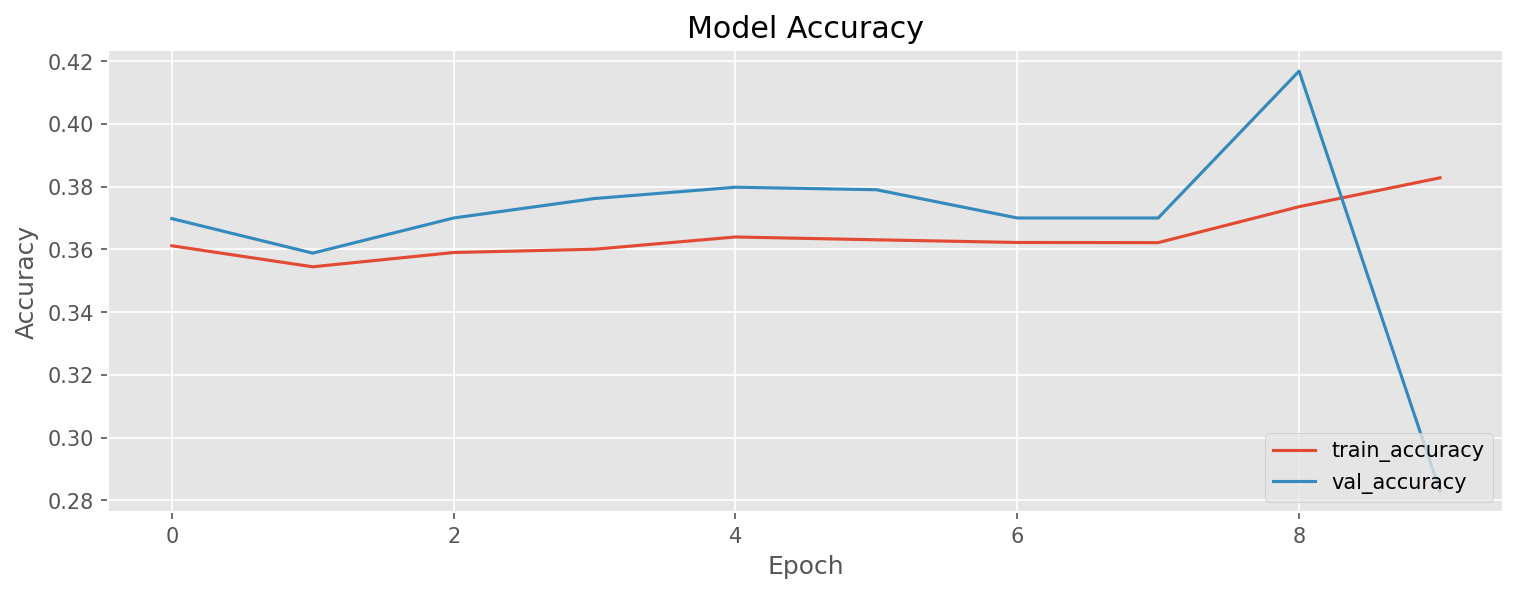

In [25]:
plt.figure(figsize=(12, 4), dpi=150)
plt.plot(history.history['accuracy'], label='train_accuracy')
plt.plot(history.history['val_accuracy'], label='val_accuracy')
plt.title('Model Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend(loc='lower right')
plt.show()

In [32]:
# Get model predictions (probabilities)
test_sequences = tokenizer.texts_to_sequences(X_test)
X_test_padded = pad_sequences(test_sequences, maxlen=max_length, padding='post', truncating='post')
y_probs = model.predict(X_test_padded)

# Converting probs into Binary values
y_pred = np.argmax(y_probs, axis=1)

196/196 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step


In [33]:
# Evaluate the model\

loss, accuracy = model.evaluate(X_test_padded, Y_test_categorical)
print(f"Loss: {loss}, Accuracy: {accuracy}")

196/196 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step - accuracy: 0.2754 - loss: 1.1685
Loss: 1.1651328802108765, Accuracy: 0.27709299325942993


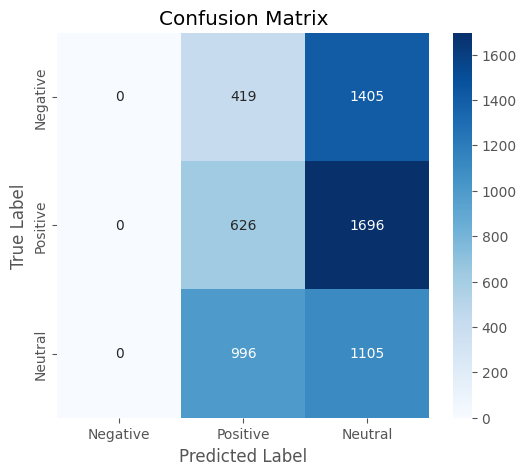

In [38]:
plt.figure(figsize=(6, 5))
sns.heatmap(confusion_matrix(np.argmax(Y_test_categorical, axis=1),np.argmax(to_categorical(y_pred, num_classes=3), axis=1) ), annot=True, fmt="d", cmap="Blues", xticklabels=['Negative' , 'Positive' , 'Neutral'], yticklabels=['Negative' , 'Positive','Neutral'])
plt.xlabel("Predicted Label")
plt.ylabel("True Label")
plt.title("Confusion Matrix")
plt.show()